In [1]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 67)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 1)
%matplotlib inline
plt.style.use('ggplot')

np.random.seed(7)
from prettytable import PrettyTable
import warnings
warnings.filterwarnings('ignore')

from IPython.core.pylabtools import figsize

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as MSE

from keras.models import Sequential
from keras import layers
from keras.layers import LSTM,Dropout
from keras.layers import Dense,Conv1D,MaxPooling1D
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences

In [2]:
kickstarter = pd.read_csv('../input/kickstarter-campaigns-dataset/kickstarter_data_full.csv', index_col=0)

In [3]:
# The dataset have 20632 entries of 67 features.
kickstarter.shape
kickstarter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20632 entries, 0 to 20631
Data columns (total 67 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           20632 non-null  int64  
 1   photo                        20632 non-null  object 
 2   name                         20632 non-null  object 
 3   blurb                        20627 non-null  object 
 4   goal                         20632 non-null  float64
 5   pledged                      20632 non-null  float64
 6   state                        20632 non-null  object 
 7   slug                         20632 non-null  object 
 8   disable_communication        20632 non-null  bool   
 9   country                      20632 non-null  object 
 10  currency                     20632 non-null  object 
 11  currency_symbol              20632 non-null  object 
 12  currency_trailing_code       20632 non-null  bool   
 13  deadline        

<AxesSubplot:>

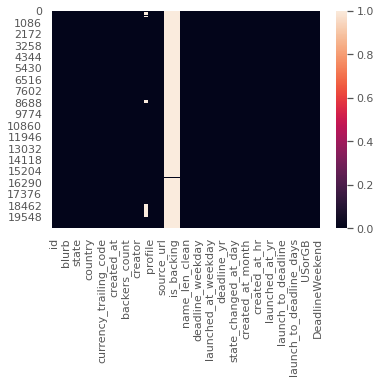

In [4]:
# looking here we can see that 'is_backing' and 'profile' contain missing values
sns.heatmap(kickstarter.isnull())

In [5]:
# friends, is_starred, is_backing, and permissions are looking weird
kickstarter['friends'].isnull().value_counts()
cols_to_drop = ['friends', 'is_starred', 'is_backing', 'permissions']
kickstarter.drop(labels=cols_to_drop, axis=1, inplace=True)
kickstarter.drop(labels='profile', axis=1, inplace=True)

In [6]:
#there are a lot of unnecessary features
second_col_drop = ['id', 
                   'photo', 
                   'slug', 
                   'currency_symbol',
                   'currency_trailing_code', 
                   'creator', 
                   'location',
                   'urls', 
                   'source_url', 
                   'name_len', 
                   'blurb_len',
                   'create_to_launch', 
                   'launch_to_deadline', 
                   'launch_to_state_change',
                   'USorGB', 
                   'TOPCOUNTRY', 
                   'LaunchedTuesday', 
                   'DeadlineWeekend',
                   'deadline_month', 'deadline_day', 'deadline_yr', 'deadline_hr', 
                   'state_changed_at_month', 'state_changed_at_day', 'state_changed_at_yr', 'state_changed_at_hr',
                   'created_at_month', 'created_at_day', 'created_at_yr', 'created_at_hr',
                   'launched_at_month', 'launched_at_day', 'launched_at_yr', 'launched_at_hr']
                   
kickstarter.drop(labels=second_col_drop, axis=1, inplace=True)

In [7]:
# we reduced dimensionality from 67 to 28
kickstarter.shape

(20632, 28)

In [8]:
kickstarter['disable_communication'] = kickstarter['disable_communication'] * 1 #converts type bool to 0 for false and 1 for true
kickstarter['staff_pick'] = kickstarter['staff_pick'] * 1 #converts type bool to 0 for false and 1 for true
kickstarter['spotlight'] = kickstarter['spotlight'] * 1 #converts type bool to 0 for false and 1 for true

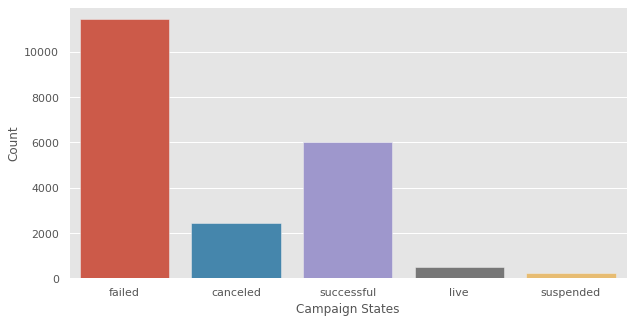

In [9]:
figsize(10, 5)
sns.countplot(kickstarter['state']);
plt.xlabel('Campaign States'); 
plt.ylabel('Count');

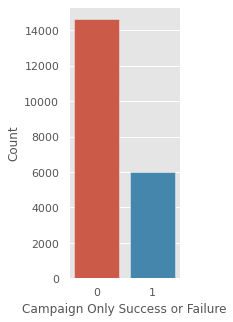

In [10]:
figsize(2, 5)
sns.countplot(kickstarter['SuccessfulBool']);
plt.xlabel('Campaign Only Success or Failure'); 
plt.ylabel('Count');

In [11]:
print("Only " 
      + str(np.round(kickstarter['SuccessfulBool'].value_counts()[1] / len(kickstarter) * 100, decimals=2)) 
      + "% of campaigns were successful.")

Only 29.17% of campaigns were successful.


In [12]:
# when we look at the general statistics, we see how each feature covers a very different range.
kickstarter.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
goal,20632.0,94104.965285,1.335511e+06,1.000000,4000.0,14000.000000,50000.000000,1.000000e+08
pledged,20632.0,21392.675739,1.204973e+05,0.000000,25.0,695.000000,5954.250000,6.225355e+06
disable_communication,20632.0,0.011148,1.049952e-01,0.000000,0.0,0.000000,0.000000,1.000000e+00
staff_pick,20632.0,0.105903,3.077215e-01,0.000000,0.0,0.000000,0.000000,1.000000e+00
backers_count,20632.0,183.675843,1.222013e+03,0.000000,2.0,12.000000,63.000000,1.058570e+05
static_usd_rate,20632.0,1.039363,2.304189e-01,0.045641,1.0,1.000000,1.000000,1.715913e+00
usd_pledged,20632.0,20915.907911,1.154717e+05,0.000000,25.0,716.301193,6004.628177,6.225355e+06
spotlight,20632.0,0.291683,4.545481e-01,0.000000,0.0,0.000000,1.000000,1.000000e+00
name_len_clean,20627.0,5.292578,2.418168e+00,1.000000,3.0,5.000000,7.000000,1.400000e+01
blurb_len_clean,20627.0,13.081204,3.283547e+00,1.000000,11.0,13.000000,15.000000,3.000000e+01


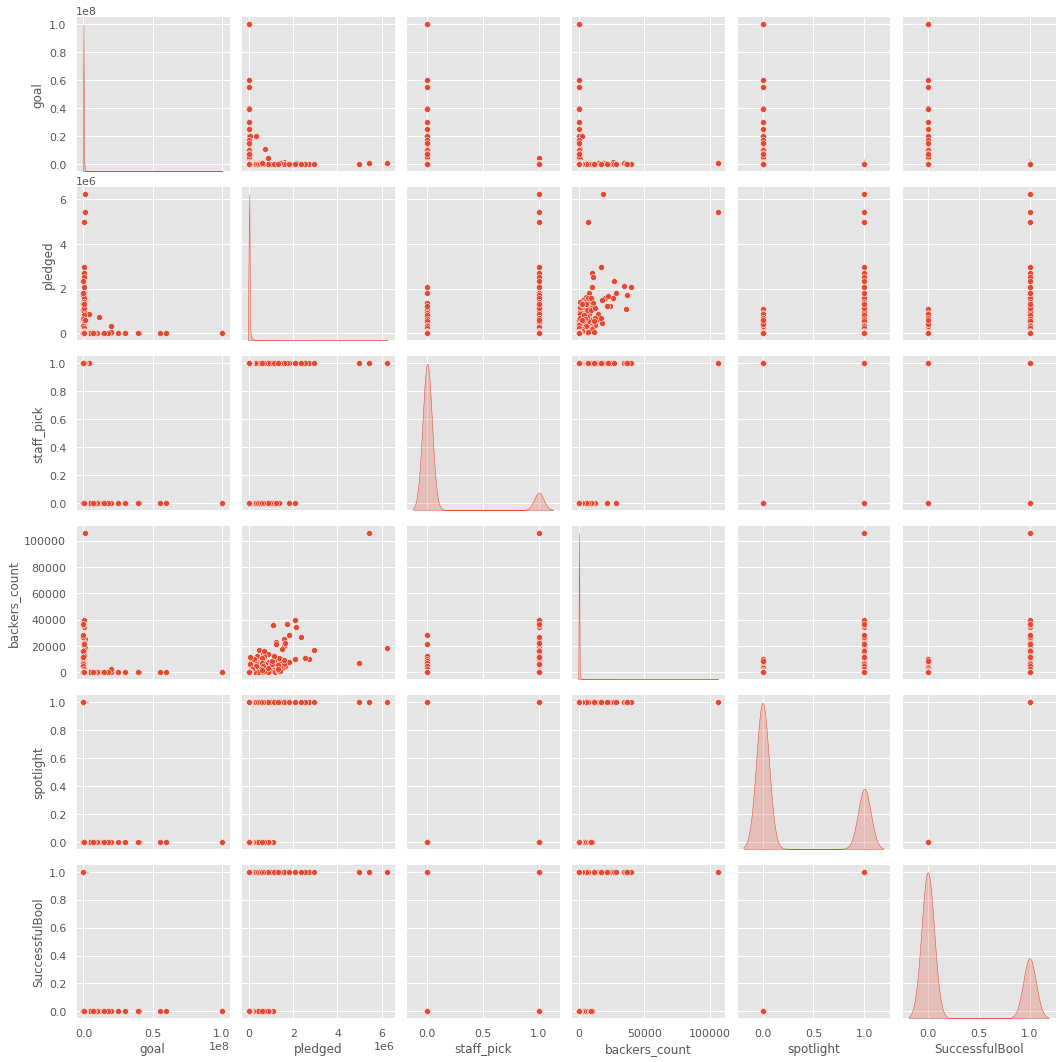

In [13]:
# Let's take a quick look at the common distribution of a few pairs of columns.
sns.pairplot(kickstarter[['goal','pledged','staff_pick', 'backers_count', 'spotlight','SuccessfulBool']], diag_kind='kde')

In [14]:
# It looks like the goal variable has a huge spread
kickstarter['goal'].sort_values().tail()

3487      40000000.0
11043     55000000.0
8678      60000000.0
4801     100000000.0
8696     100000000.0
Name: goal, dtype: float64

In [15]:
# the pledged amount is more reasonable because this represents real money that people decided to give
kickstarter['pledged'].sort_values().tail()

8763     2708472.39
12829    2952508.59
12911    4961032.74
4363     5408916.95
8805     6225354.98
Name: pledged, dtype: float64

In [16]:
first_quartile = kickstarter['goal'].describe()['25%']
third_quartile = kickstarter['goal'].describe()['75%']
iqr = third_quartile - first_quartile
kickstarter_goal_iqr = kickstarter[(kickstarter['goal'] > first_quartile) & (kickstarter['goal'] < third_quartile)]

In [17]:
kickstarter_goal_iqr.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
goal,10107.0,16841.510237,10887.732017,4059.000000,8000.0,15000.0,25000.00,4.999900e+04
pledged,10107.0,14891.312073,67578.044235,0.000000,28.0,840.0,8489.00,2.344135e+06
disable_communication,10107.0,0.011477,0.106520,0.000000,0.0,0.0,0.00,1.000000e+00
staff_pick,10107.0,0.109330,0.312068,0.000000,0.0,0.0,0.00,1.000000e+00
backers_count,10107.0,173.063125,907.532746,0.000000,2.0,13.0,82.00,3.678100e+04
static_usd_rate,10107.0,1.036482,0.202281,0.045704,1.0,1.0,1.00,1.715913e+00
usd_pledged,10107.0,15099.692854,67484.061872,0.000000,29.0,850.0,8618.75,2.344135e+06
spotlight,10107.0,0.266053,0.441914,0.000000,0.0,0.0,1.00,1.000000e+00
name_len_clean,10105.0,5.366452,2.431118,1.000000,3.0,6.0,7.00,1.400000e+01
blurb_len_clean,10105.0,13.073726,3.285475,1.000000,11.0,13.0,15.00,3.000000e+01


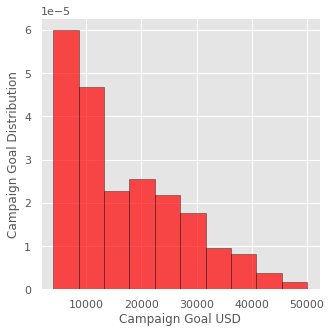

In [18]:
figsize(5, 5)   
plt.hist(kickstarter_goal_iqr['goal'], 10, 
                            density = 10, 
                            color ='red',
                            edgecolor = 'black',
                            alpha = 0.7)
  
plt.xlabel('Campaign Goal USD')
plt.ylabel('Campaign Goal Distribution')  
plt.show()

In [19]:
# trim backers_count, pledged and create_to_launch_days then create a new IQR dataframe with these truncated values

kickstarter_iqr_trimmed = kickstarter_goal_iqr

first_quartile = kickstarter['create_to_launch_days'].describe()['25%']
third_quartile = kickstarter['create_to_launch_days'].describe()['75%']

iqr = third_quartile - first_quartile

kickstarter_iqr_trimmed = kickstarter[(kickstarter['create_to_launch_days'] > first_quartile) & (kickstarter['create_to_launch_days'] < third_quartile)]

first_quartile = kickstarter['pledged'].describe()['25%']
third_quartile = kickstarter['pledged'].describe()['75%']

iqr = third_quartile - first_quartile

kickstarter_iqr_trimmed = kickstarter[(kickstarter['pledged'] > first_quartile) & (kickstarter['pledged'] < third_quartile)]

first_quartile = kickstarter['backers_count'].describe()['25%']
third_quartile = kickstarter['backers_count'].describe()['75%']

iqr = third_quartile - first_quartile

kickstarter_iqr_trimmed = kickstarter[(kickstarter['backers_count'] > first_quartile) & (kickstarter['backers_count'] < third_quartile)]

In [20]:
# This reduction resulted in a dataframe where there are 9308 instances,
# with only the IQR for the variables in question remaining.
len(kickstarter_iqr_trimmed)

9308

In [21]:
# correlations between each variable against SuccessfulBool, which remember, is a binary value where 0=failed and 1=succeeded.
kickstarter_iqr_trimmed.corr()['SuccessfulBool'].sort_values()

launch_to_deadline_days       -0.184938
create_to_launch_days         -0.085983
disable_communication         -0.053091
launch_to_state_change_days   -0.047071
goal                          -0.033484
name_len_clean                -0.027807
blurb_len_clean                0.058825
staff_pick                     0.109232
static_usd_rate                0.109604
pledged                        0.133948
usd_pledged                    0.181088
backers_count                  0.404936
spotlight                      1.000000
SuccessfulBool                 1.000000
Name: SuccessfulBool, dtype: float64

In [22]:
# Looking at the correlations above we can see that nothing is too strongly correlated except spotlight, backers_count, pledged, and staff_pick
# But really the only significant ones are backers_count and spotlight

len(kickstarter_iqr_trimmed[kickstarter_iqr_trimmed['spotlight'] == 1])

2200

In [23]:
# taken together with the spotlight variable's correlation to SuccessfulBool,
# we can conclude that all spotlighted campaigns were successful, at least in this dataset,
# taking into account the fact that it is reduced to IQR values only

len(kickstarter_iqr_trimmed[kickstarter_iqr_trimmed['SuccessfulBool'] == 1])

2200

In [24]:
# we are going to pool together these strongly correlated features for feature selection
reduced_x_features = kickstarter_iqr_trimmed[['launch_to_deadline_days', 'staff_pick', 'pledged', 'backers_count', 'spotlight', 'goal']]
reduced_y = kickstarter_iqr_trimmed[['SuccessfulBool']]

In [25]:
# # we are going to pool together these strongly correlated features for feature selection
# reduced_x_features = kickstarter_iqr_trimmed[['launch_to_deadline_days', 'staff_pick', 'SuccessfulBool', 'backers_count', 'spotlight', 'goal']]
# reduced_y = kickstarter_iqr_trimmed[['pledged']]

In [26]:
# Because of the original format of the variables, we need to take the log and sqrt transformations of them and 
# check correlation with those as well to account for non-linear relationships

numeric_subset = kickstarter_iqr_trimmed.select_dtypes('number')

for col in numeric_subset.columns:
    if col == 'SuccessfulBool':
        next
    else:
        numeric_subset['sqrt_' + col] = np.sqrt(numeric_subset[col])
        numeric_subset['log_' + col] = np.log(numeric_subset[col])

categorical_subset = kickstarter_iqr_trimmed['category']

categorical_subset = pd.get_dummies(categorical_subset)
features = pd.concat([numeric_subset, categorical_subset], axis = 1)
features = features.dropna(subset = ['SuccessfulBool'])

correlations = features.corr()['SuccessfulBool'].dropna().sort_values()
correlations.head()

log_goal                       -0.554957
sqrt_goal                      -0.272015
log_launch_to_deadline_days    -0.219717
sqrt_launch_to_deadline_days   -0.205036
launch_to_deadline_days        -0.184938
Name: SuccessfulBool, dtype: float64

In [27]:
# we saw in the previous step that goal got a boost in correlation what you take its log,
# so we will add log_goal into the reduced_x_features dataframe and 
# saw log_pledged show a significant boost as well, so that will be included

reduced_x_features['log_goal'] = features['log_goal']
reduced_x_features['log_pledged'] = features['log_pledged']
#reduced_x_features.drop('pledged', axis=1, inplace=True)

In [28]:
reduced_x_features

,launch_to_deadline_days,staff_pick,pledged,backers_count,spotlight,goal,log_goal,log_pledged
2,60,0,120.0,5,0,100000.0,11.512925,4.787492
4,32,0,356.0,17,0,3222.0,8.077758,5.874931
5,30,0,1136.0,12,0,13000.0,9.472705,7.035269
8,30,0,153.0,7,0,6000.0,8.699515,5.030438
10,30,0,72.0,5,0,7300.0,8.895630,4.276666
...,...,...,...,...,...,...,...,...
20624,30,0,761.0,4,0,40000.0,10.596635,6.634633
20625,60,0,3075.0,34,0,20000.0,9.903488,8.031060
20626,35,0,101.0,9,0,5000.0,8.517193,4.615121
20628,30,0,1559.0,13,0,100000.0,11.512925,7.351800


In [29]:
reduced_y

,SuccessfulBool
2,0
4,0
5,0
8,0
10,0
...,...
20624,0
20625,0
20626,0
20628,0


<AxesSubplot:>

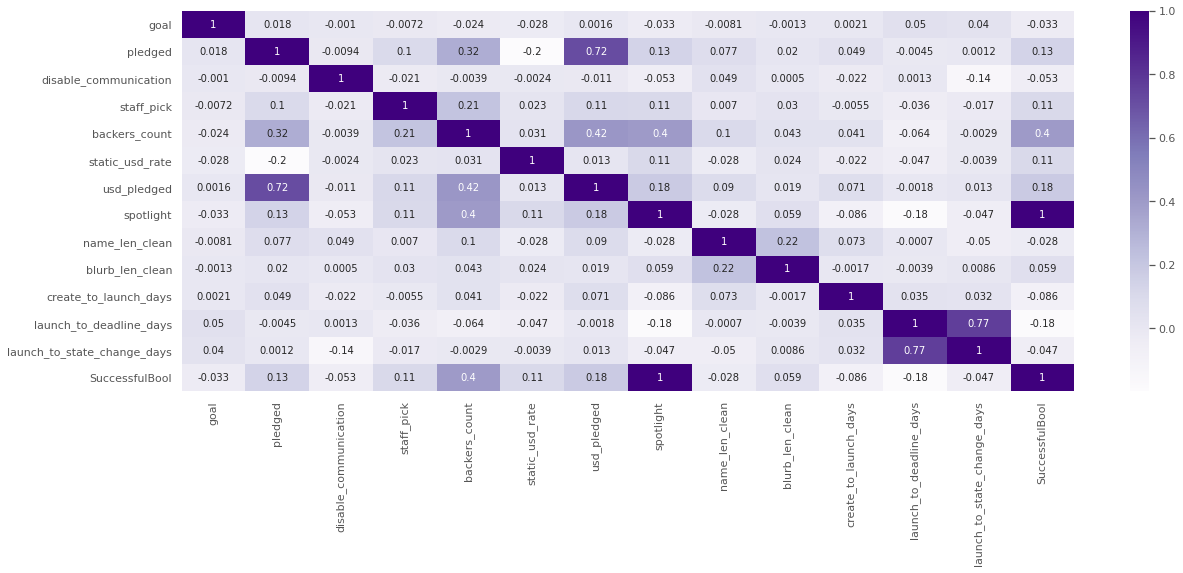

In [30]:
# Feature engineering is the process of creating new features from existing ones in a sense, 
# so when we transformed goal and pledged to log_goal and log_pledged, 
# we found that these had a stronger correlation than their original forms,
# so these new features were added to reduced_x_feature
figsize(20,7)
sns.heatmap(kickstarter_iqr_trimmed.corr(), annot=True, annot_kws={"size": 10}, cmap="Purples")


In [31]:
kickstarter_X = []
kickstarter_y = []
for i, j in reduced_x_features.iterrows():
    tmp = str(reduced_x_features['launch_to_deadline_days'][i]) + " " + \
        str(reduced_x_features['staff_pick'][i]) + " " + \
        str(reduced_x_features['backers_count'][i]) + " " + \
        str(reduced_x_features['spotlight'][i]) + " " + \
        str(reduced_x_features['goal'][i]) + " " + \
        str(reduced_x_features['log_goal'][i]) + " " + \
        str(reduced_x_features['log_pledged'][i])  
    kickstarter_X.append(tmp)
    kickstarter_y.append(reduced_y['SuccessfulBool'][i])

In [32]:
# kickstarter_X = []
# kickstarter_y = []
# for i, j in reduced_x_features.iterrows():
#     tmp = str(reduced_x_features['launch_to_deadline_days'][i]) + " " + \
#         str(reduced_x_features['staff_pick'][i]) + " " + \
#         str(reduced_x_features['backers_count'][i]) + " " + \
#         str(reduced_x_features['spotlight'][i]) + " " + \
#         str(reduced_x_features['goal'][i]) + " " + \
#         str(reduced_x_features['log_goal'][i]) + " " + \
#         str(reduced_x_features['log_pledged'][i])
#     kickstarter_X.append(tmp)
#     kickstarter_y.append(reduced_y['pledged'][i])

In [33]:
# kickstarter_X

In [34]:
# kickstarter_y

In [35]:
print(len(kickstarter_X), len(kickstarter_y))

9308 9308


In [36]:
max_words = 2000
max_length = 30
vector_length = 16

encoded_docs = [one_hot(d, max_words) for d in kickstarter_X]
padded_docs = pad_sequences(encoded_docs, maxlen=7, padding='post')

X_train, X_test, y_train, y_test = train_test_split(padded_docs, np.array(kickstarter_y)[:, None].astype(int), test_size=0.20, random_state=1234)

In [37]:
print("X_train")
X_train

X_train


array([[1482, 1237, 1482, ...,  987,  242,  699],
       [  26, 1827, 1482, ..., 1996,  242, 1371],
       [1482, 1530, 1482, ...,  881,  734,  714],
       ...,
       [1482, 1948, 1482, ..., 1059,  242, 1466],
       [  26,  988, 1482, ..., 1471, 1419, 1786],
       [  26,  865, 1482, ..., 1960, 1645,  341]], dtype=int32)

In [38]:
print("X_test")
X_test

X_test


array([[1482, 1955, 1482, ...,  202,  506,  874],
       [1482, 1810, 1482, ...,  516, 1419, 1112],
       [1482, 1271, 1482, ..., 1163,  429, 1171],
       ...,
       [  26,  665, 1482, ..., 1065, 1567,  989],
       [1482, 1827, 1482, ..., 1996, 1419,  674],
       [1482,  472, 1482, ..., 1417, 1567,  543]], dtype=int32)

In [39]:
print("y_train")
y_train

y_train


array([[0],
       [1],
       [0],
       ...,
       [0],
       [1],
       [1]])

In [40]:
print("y_test")
y_test

y_test


array([[0],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]])

#------------- CNN -------------#

In [41]:
# Initialising the RNN
model = Sequential()
model.add(layers.Embedding(max_words+1, vector_length, input_length=max_length))
model.add(Conv1D(filters=32, kernel_size=7, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Adding the first CNN layer and Dropout layer
model.add(Dense(128, activation="relu", input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))

# Adding a second CNN layer and Dropout layer
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))

# Adding a third CNN layer and Dropout layer
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.2))

# Adding a fourth CNN layer and Dropout layer
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.2))

# For Full connection layer we use dense
# As the output is 1D so we use unit=1
# Adding the output layer
model.add(Dense(1))
# model.add(Dense(1, activation= 'linear'))

print(model.summary())
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['mse'])

history = model.fit(X_train, y_train, 
          epochs=50, 
          verbose=1,
          validation_data=(X_test, y_test),
          batch_size=256)

scores = model.evaluate(X_test, y_test,
                        verbose=1,
                        batch_size = 256)

dt = RandomForestRegressor(criterion='mse',n_jobs=-1, n_estimators=10, max_depth=6, min_samples_leaf=1, random_state=3)
dt.fit(X_train,y_train)
y_predicted = dt.predict(X_test)
accuracy = dt.score(X_test,y_test)
MSE_score = MSE(y_test,y_predicted)

# print the final results
print("Training Accuracy:",(dt.score(X_train,y_train)))
print("Testing Accuracy:",accuracy)
print("Mean Squared Error",MSE_score.mean())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 16)            32016     
_________________________________________________________________
conv1d (Conv1D)              (None, 30, 32)            3616      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 15, 32)            0         
_________________________________________________________________
dense (Dense)                (None, 15, 128)           4224      
_________________________________________________________________
dropout (Dropout)            (None, 15, 128)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 15, 64)            8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 64)            0

In [42]:
table = PrettyTable(border=True, header=True, padding_width=1)
table.field_names = ['X', 'y (actual)', 'Predicted']
table.add_row([X_test[15], y_test[15], y_predicted[15]])
table.add_row([X_test[25], y_test[25], y_predicted[25]])
table.add_row([X_test[40], y_test[40], y_predicted[40]])
table.add_row([X_test[47], y_test[47], y_predicted[47]])
table.add_row([X_test[85], y_test[85], y_predicted[85]])
table.add_row([X_test[110], y_test[110], y_predicted[110]])
table.add_row([X_test[202], y_test[202], y_predicted[202]])
table.add_row([X_test[1848], y_test[1848], y_predicted[1848]])
table.add_row([X_test[1857], y_test[1857], y_predicted[1857]])

print(table)

+--------------------------------------+------------+-----------+
|                  X                   | y (actual) | Predicted |
+--------------------------------------+------------+-----------+
| [1482  141 1482  242 1740 1645  520] |    [0]     |    0.0    |
| [  26 1379 1482  429 1281  429  937] |    [1]     |    1.0    |
| [1482 1234 1482  242  452  506  780] |    [0]     |    0.0    |
| [1482  355 1482 1313 1859 1915 1293] |    [0]     |    0.0    |
| [  26   81 1482  865 1260  865 1198] |    [1]     |    1.0    |
| [1482  934 1482  242  842 1567  906] |    [0]     |    0.0    |
| [1482  673 1482 1190 1038 1645  298] |    [0]     |    0.0    |
| [1482  441 1482 1190 1885  506  191] |    [0]     |    0.0    |
| [  26  415 1482  429 1488  429 1488] |    [1]     |    1.0    |
+--------------------------------------+------------+-----------+


#------------- LSTM -------------#


In [43]:
# Initialising the RNN
model = Sequential()
model.add(layers.Embedding(max_words+1, vector_length, input_length=max_length))

# Adding the first LSTM layer and Dropout layer
model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and Dropout layer
model.add(LSTM(units = 64, return_sequences = True))
model.add(Dropout(0.2))

# Adding a third LSTM layer and Dropout layer
model.add(LSTM(units = 32, return_sequences = True))
model.add(Dropout(0.2))

# Adding a fourth LSTM layer and Dropout layer
model.add(LSTM(units = 16))
model.add(Dropout(0.2))

# For Full connection layer we use dense
# As the output is 1D so we use unit=1
# Adding the output layer
model.add(Dense(1))
# model.add(Dense(1, activation= 'linear'))

print(model.summary())
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['mse'])

history = model.fit(X_train, y_train, 
          epochs=50, 
          verbose=1,
          validation_data=(X_test, y_test),
          batch_size=256)

loss, accuracy = model.evaluate(X_train, y_train, verbose=1)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print("Testing Accuracy:  {:.4f}".format(accuracy))

scores = model.evaluate(X_test, y_test,
                        verbose=1,
                        batch_size = 256)

dt = RandomForestRegressor(criterion='mse',n_jobs=-1, n_estimators=10,max_depth=6, min_samples_leaf=1, random_state=3)
dt.fit(X_train,y_train)
y_predicted = dt.predict(X_test)
accuracy = dt.score(X_test,y_test)
MSE_score = MSE(y_test,y_predicted)

# print the final results
print("Training Accuracy:",dt.score(X_train,y_train))
print("Testing Accuracy:",accuracy)
print("Mean Squared Error",MSE_score.mean())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 16)            32016     
_________________________________________________________________
lstm (LSTM)                  (None, 30, 128)           74240     
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 64)            49408     
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 32)            12416     
_________________________________________________________________
dropout_6 (Dropout)          (None, 30, 32)           

In [44]:
table = PrettyTable(border=True, header=True, padding_width=1)
table.field_names = ['X', 'y (actual)', 'Predicted']
table.add_row([X_test[15], y_test[15], y_predicted[15]])
table.add_row([X_test[25], y_test[25], y_predicted[25]])
table.add_row([X_test[40], y_test[40], y_predicted[40]])
table.add_row([X_test[47], y_test[47], y_predicted[47]])
table.add_row([X_test[85], y_test[85], y_predicted[85]])
table.add_row([X_test[110], y_test[110], y_predicted[110]])
table.add_row([X_test[202], y_test[202], y_predicted[202]])
table.add_row([X_test[1848], y_test[1848], y_predicted[1848]])
table.add_row([X_test[1857], y_test[1857], y_predicted[1857]])

print(table)

+--------------------------------------+------------+-----------+
|                  X                   | y (actual) | Predicted |
+--------------------------------------+------------+-----------+
| [1482  141 1482  242 1740 1645  520] |    [0]     |    0.0    |
| [  26 1379 1482  429 1281  429  937] |    [1]     |    1.0    |
| [1482 1234 1482  242  452  506  780] |    [0]     |    0.0    |
| [1482  355 1482 1313 1859 1915 1293] |    [0]     |    0.0    |
| [  26   81 1482  865 1260  865 1198] |    [1]     |    1.0    |
| [1482  934 1482  242  842 1567  906] |    [0]     |    0.0    |
| [1482  673 1482 1190 1038 1645  298] |    [0]     |    0.0    |
| [1482  441 1482 1190 1885  506  191] |    [0]     |    0.0    |
| [  26  415 1482  429 1488  429 1488] |    [1]     |    1.0    |
+--------------------------------------+------------+-----------+


In [45]:
# table = PrettyTable(border=True, header=True, padding_width=1)
# table.field_names = ['Model', 'Accuracy']
# table.add_row(['CNN', '--%'])
# table.add_row(['LSTM', "--%"])

# print(table)